In [12]:
# Install prerequisites for evaluation
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import interp1d
import importlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from os import listdir, path
from IPython.display import display, Markdown
import math

import os
import sys

# if current working directory includes "evaluation" change to parent directory
if "evaluation" in os.getcwd():
    os.chdir("..")
    # Add parent directory to sys.path
    sys.path.append(os.getcwd())



# Verify
print(f"Current working directory: {os.getcwd()}")
print(f"sys.path: {sys.path}")

Current working directory: /root/oxn
sys.path: ['/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/root/oxn/venv/lib/python3.11/site-packages', '/root/oxn']


# Short Setup Test

In [2]:
# Import report
from gevent import monkey
monkey.patch_all()
import evaluation.evaluation as evaluation


importlib.reload(evaluation)

from evaluation.evaluation import Report

assert os.path.exists("reports"), "No reports directory found. Please run the experiments first."

files_in_direcotry = listdir("reports")

# sort them by date
files_in_direcotry.sort(key=lambda x: path.getctime(path.join("reports",x)))

# Load the last experiment
last_experiment = files_in_direcotry[-1]

report_path = path.join("reports", last_experiment.replace(".yaml",".yaml"))
report = Report.from_file(report_path)
print(f"Loaded report {last_experiment}")

assert report is not None, "No report found. Please run the experiments first."
assert isinstance(report, Report), "Report is not of type Report"


assert report.interactions is not None, "No interactions found."
assert report.interactions[0] is not None, "No interactions found. "
assert report.interactions[0].response_data is not None, "No data in interaction found"


Loaded report report_2024-11-18_19-46-28.yaml


Reload evaluation file and caches (mainly for dev)

In [3]:
# Patch all and reload evaluation module
monkey.patch_all()
importlib.reload(evaluation)

# cache the dataframes
cached_dataframes_kepler_pods = []
cached_dataframes_kepler_namespace = []

In [51]:

# Function to load a report and extract specific interactions
def load_report_interactions(report_directory, report_name, response_name, treatment_name):
    report_path = os.path.join(report_directory, report_name)
    if os.path.exists(report_path):
        report = Report.from_file(report_path)
        #print(report.interactions)
        selected_interactions = [
            interaction for interaction in report.interactions
            if interaction.response_name == response_name and interaction.treatment_name == treatment_name
        ]
        print(f"Found {len(selected_interactions)} interactions for {report_name} and {treatment_name}.")
        return selected_interactions[0] if selected_interactions else None
    else:
        print(f"Report {report_name} not found.")
        return None      
        
def load_reports_and_normalize_time(cached_dataframes, report_directory, response_name, treatment_names, report_names):
    response_dataframes = cached_dataframes or []
    # Load the interactions if not already loaded
    if not response_dataframes or len(response_dataframes) == 0:
        print(f"Loading dataframes from reports because cached dataframes are empty.")
        for report_name in report_names:
            for treatment_name in treatment_names:
                interaction = load_report_interactions(report_directory, report_name, response_name, treatment_name)
                if interaction:
                    #print(interaction)
                    #print(interaction.response_data)
                    # Add columns to identify the treatment and report
                    interaction.response_data["treatment"] = f"{report_name}_{treatment_name}"
                    interaction.response_data["treatment_start"] = interaction.treatment_start
                    interaction.response_data["treatment_end"] = interaction.treatment_end
                    response_dataframes.append(interaction.response_data.copy())  # Make an explicit copy
    else:
        print("Using cached dataframes.")
    cached_dataframes = response_dataframes

    # Normalize time and concatenate all dataframes
    if response_dataframes:
        normalized_dataframes = []
        treatment_start_time = None
        treatment_end_time = None

        assert isinstance(response_dataframes, list)

        for df in response_dataframes:
            assert isinstance(df, pd.DataFrame)
            # Convert index to datetime if needed and ensure both index and treatment_start have the same timezone
            if not pd.api.types.is_datetime64_any_dtype(df.index):
                df.index = pd.to_datetime(df.index)

            # Convert treatment_start and treatment_end to datetime if not already
            current_treatment_start = pd.to_datetime(df["treatment_start"].iloc[0])
            current_treatment_end = pd.to_datetime(df["treatment_end"].iloc[0])

            # Ensure both are timezone-naive or the same timezone-aware if applicable
            df.index = df.index.tz_localize(None)
            current_treatment_start = current_treatment_start.tz_localize(None)
            current_treatment_end = current_treatment_end.tz_localize(None)

            # Calculate the interval between data points in seconds
            time_interval = (df.index[1] - df.index[0]).total_seconds()

            # Add the experiment_seconds column
            df = df.copy()  # Work with a copy to avoid modifying a view
            df.loc[:, "experiment_seconds"] = (df.index - current_treatment_start).total_seconds()
            df.loc[:, "time_normalized"] = df["experiment_seconds"]

            # Set or verify consistent treatment start and end times for plotting
            if treatment_start_time is None:
                treatment_start_time = current_treatment_start
                treatment_end_time = current_treatment_end
            else:
                if treatment_start_time != current_treatment_start or treatment_end_time != current_treatment_end:
                    print(f"Warning: Inconsistent treatment start or end times for report {df['treatment'].iloc[0]}.")

            normalized_dataframes.append(df)
    else:
        print("No valid interactions found for the specified treatment names.")


    # Combine all the normalized dataframes
    combined_df = pd.concat(normalized_dataframes)
    return cached_dataframes, combined_df, treatment_start_time, treatment_end_time

def plot_kepler_metrics_per_pod(combined_df, response_name, treatment_end_time, treatment_start_time):

    # Normalize t0 and t1 to seconds relative to treatment start time
    treatment_start_seconds = 0  # t0 is always 0 after normalization
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()

    # Get unique container names
    container_names = combined_df["container_name"].unique()

    # Determine the grid size for subplots
    num_containers = len(container_names)
    num_cols = 2  # Define the number of columns for the grid
    num_rows = math.ceil(num_containers / num_cols)

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()  # Flatten in case of a 2D array to make iteration easier

    # Plot the data for each container_name in a subplot
    for idx, container_name in enumerate(container_names):
        ax = axes[idx]
        assert isinstance(ax, plt.Axes)
        container_df = combined_df[combined_df["container_name"] == container_name]

        for treatment, df in container_df.groupby("treatment"):
            #print(df["experiment_seconds"])
            ax.plot(df["experiment_seconds"], df[response_name], label=f"{treatment}")

        # Add vertical lines for treatment start and end times (normalized)
        ax.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
        ax.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")

        ax.set_title(f"Container: {container_name}")
        ax.set_xlabel("Time (seconds from experiment start)")
        ax.set_ylabel(response_name)
        #ax.set_xticks(range(0, int(treatment_end_seconds) + 1, 60))  # Show ticks every minute
        ax.set_xlim(-250, treatment_end_seconds + 250)
        ax.legend()
        ax.grid()

    # Hide any unused subplots
    for idx in range(num_containers, len(axes)):
        fig.delaxes(axes[idx])

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
def plot_kepler_metrics_per_pod_seaborn(combined_df, response_name, treatment_end_time, treatment_start_time):
    # Normalize t0 and t1 to seconds relative to treatment start time
    treatment_start_seconds = 0  # t0 is always 0 after normalization
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()

    # Get unique container names
    container_names = combined_df["container_name"].unique()

    # Determine the grid size for subplots
    num_containers = len(container_names)
    num_cols = 2  # Define the number of columns for the grid
    num_rows = math.ceil(num_containers / num_cols)

    # Set the style for seaborn
    sns.set(style="whitegrid")

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()  # Flatten in case of a 2D array to make iteration easier

    # Plot the data for each container_name in a subplot
    for idx, container_name in enumerate(container_names):
        ax = axes[idx]
        container_df = combined_df[combined_df["container_name"] == container_name]

        # Interpolate the data for smoothing
        for treatment, df in container_df.groupby("treatment"):
            if len(df) > 1:
                f = interp1d(df["experiment_seconds"], df[response_name], kind='cubic')
                experiment_seconds_new = np.linspace(df["experiment_seconds"].min(), df["experiment_seconds"].max(), num=500)
                response_interpolated = f(experiment_seconds_new)
                sns.lineplot(
                    x=experiment_seconds_new,
                    y=response_interpolated,
                    ax=ax,
                    label=f"{treatment}",
                    palette="tab10",
                    linewidth=2
                )
            else:
                print(f"Only one data point for {container_name} in treatment {treatment}.")
                """ sns.lineplot(
                    data=df,
                    x="experiment_seconds",
                    y=response_name,
                    ax=ax,
                    label=f"{treatment}",
                    palette="tab10",
                    linewidth=2
                ) """

        # Add vertical lines for treatment start and end times (normalized)
        ax.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
        ax.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")

        ax.set_title(f"Container: {container_name}")
        ax.set_xlabel("Time (seconds from experiment start)")
        ax.set_ylabel("Watt")
        ax.set_xlim(-250, treatment_end_seconds + 250)
        ax.legend()

    # Hide any unused subplots
    for idx in range(num_containers, len(axes)):
        fig.delaxes(axes[idx])

    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_kepler_metrics_per_pod_seaborn_with_fill_below(combined_df, response_name, treatment_end_time, treatment_start_time):
    # Normalize t0 and t1 to seconds relative to treatment start time
    treatment_start_seconds = 0  # t0 is always 0 after normalization
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()

    # Get unique container names
    container_names = combined_df["container_name"].unique()

    # Determine the grid size for subplots
    num_containers = len(container_names)
    num_cols = 2  # Define the number of columns for the grid
    num_rows = math.ceil(num_containers / num_cols)

    # Set the style for seaborn
    sns.set(style="whitegrid")

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()  # Flatten in case of a 2D array to make iteration easier

    # Plot the data for each container_name in a subplot
    for idx, container_name in enumerate(container_names):
        ax = axes[idx]
        container_df = combined_df[combined_df["container_name"] == container_name]

        # Interpolate the data for smoothing
        for treatment, df in container_df.groupby("treatment"):
            if len(df) > 1:
                f = interp1d(df["experiment_seconds"], df[response_name], kind='cubic')
                experiment_seconds_new = np.linspace(df["experiment_seconds"].min(), df["experiment_seconds"].max(), num=500)
                response_interpolated = f(experiment_seconds_new)
                ax.plot(
                    experiment_seconds_new,
                    response_interpolated,
                    label=f"{treatment}",
                    linewidth=2
                )
                ax.fill_between(
                    experiment_seconds_new,
                    response_interpolated,
                    alpha=0.2
                )
            else:
                sns.lineplot(
                    data=df,
                    x="experiment_seconds",
                    y=response_name,
                    ax=ax,
                    label=f"{treatment}",
                    palette="tab10",
                    linewidth=2
                )
                ax.fill_between(
                    df["experiment_seconds"],
                    df[response_name],
                    alpha=0.3
                )

        # Add vertical lines for treatment start and end times (normalized)
        ax.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
        ax.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")

        ax.set_title(f"Container: {container_name}")
        ax.set_xlabel("Time (seconds from experiment start)")
        ax.set_ylabel(response_name)
        ax.set_xlim(-250, treatment_end_seconds + 250)
        ax.legend()

    # Hide any unused subplots
    for idx in range(num_containers, len(axes)):
        fig.delaxes(axes[idx])

    # Adjust layout
    plt.tight_layout()
    plt.show()

        
def plot_kepler_metrics(combined_df, response_name, treatment_end_time, treatment_start_time, container_namespace):

    # Normalize t0 and t1 to seconds relative to treatment start time
    treatment_start_seconds = 0  # t0 is always 0 after normalization
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()
    
    fig, ax = plt.subplots(figsize=(12, 6))

    

    namespace_df = combined_df[combined_df["container_namespace"] == container_namespace]

    #print(namespace_df)

    for treatment, df in namespace_df.groupby("treatment"):
        print(df["experiment_seconds"])
        ax.plot(df["experiment_seconds"], df[response_name], label=f"{treatment}")

    # Add vertical lines for treatment start and end times (normalized)
    ax.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
    ax.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")

    ax.set_title(f"Namespace: {container_namespace}")
    ax.set_xlabel("Time (seconds from experiment start)")
    ax.set_ylabel(response_name)
    #ax.set_xticks(range(0, int(treatment_end_seconds) + 1, 60))  # Show ticks every minute
    ax.set_xlim(-250, treatment_end_seconds + 250)
    ax.set_ylim(40, 70)
    
    ax.legend()
    ax.grid()

    
    # Adjust layout
    plt.tight_layout()
    plt.show()
   
def plot_kepler_metrics_seaborn(combined_df, response_name, treatment_end_time, treatment_start_time, container_namespace):
    # Normalize t0 and t1 to seconds relative to treatment start time
    treatment_start_seconds = 0  # t0 is always 0 after normalization
    treatment_end_seconds = (treatment_end_time - treatment_start_time).total_seconds()
    
    fig, ax = plt.subplots(figsize=(12, 6))

    namespace_df = combined_df[combined_df["container_namespace"] == container_namespace]

    for treatment, df in namespace_df.groupby("treatment"):
        # Interpolate to make it smoother
        x = df["experiment_seconds"]
        y = df[response_name]

        f_interpolate = interp1d(x, y, kind='cubic', fill_value='extrapolate')
        x_smooth = np.linspace(x.min(), x.max(), 500)
        y_smooth = f_interpolate(x_smooth)

        sns.lineplot(x=x_smooth, y=y_smooth, label=f"{treatment}", ax=ax)
        ax.fill_between(x_smooth, y_smooth, alpha=0.2)

    # Add vertical lines for treatment start and end times (normalized)
    ax.axvline(x=treatment_start_seconds, color="r", linewidth=1, linestyle="--", label="t0")
    ax.axvline(x=treatment_end_seconds, color="r", linewidth=1, linestyle="--", label="t1")

    ax.set_title(f"Namespace: {container_namespace}")
    ax.set_xlabel("Time (seconds from experiment start)")
    ax.set_ylabel(response_name)
    ax.set_xlim(-250, treatment_end_seconds + 250)
    ax.set_ylim(40, 70)
    
    ax.legend()
    ax.grid()

    # Adjust layout
    plt.tight_layout()
    plt.show()

Using cached dataframes.


/tmp/ipykernel_121403/2729340863.py:164: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/tmp/ipykernel_121403/2729340863.py:164: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/tmp/ipykernel_121403/2729340863.py:164: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/tmp/ipykernel_121403/2729340863.py:164: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/tmp/ipykernel_121403/2729340863.py:164: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/tmp/ipykernel_121403/2729340863.py:164: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/tmp/ipykernel_121403/2729340863.py:164: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/tmp/ipykernel_121403/2729340863.py:164: UserWarning: Ignoring

Only one data point for oxn-steering-container in treatment report_2024-11-18_19-46-28.yaml_empty_treatment.


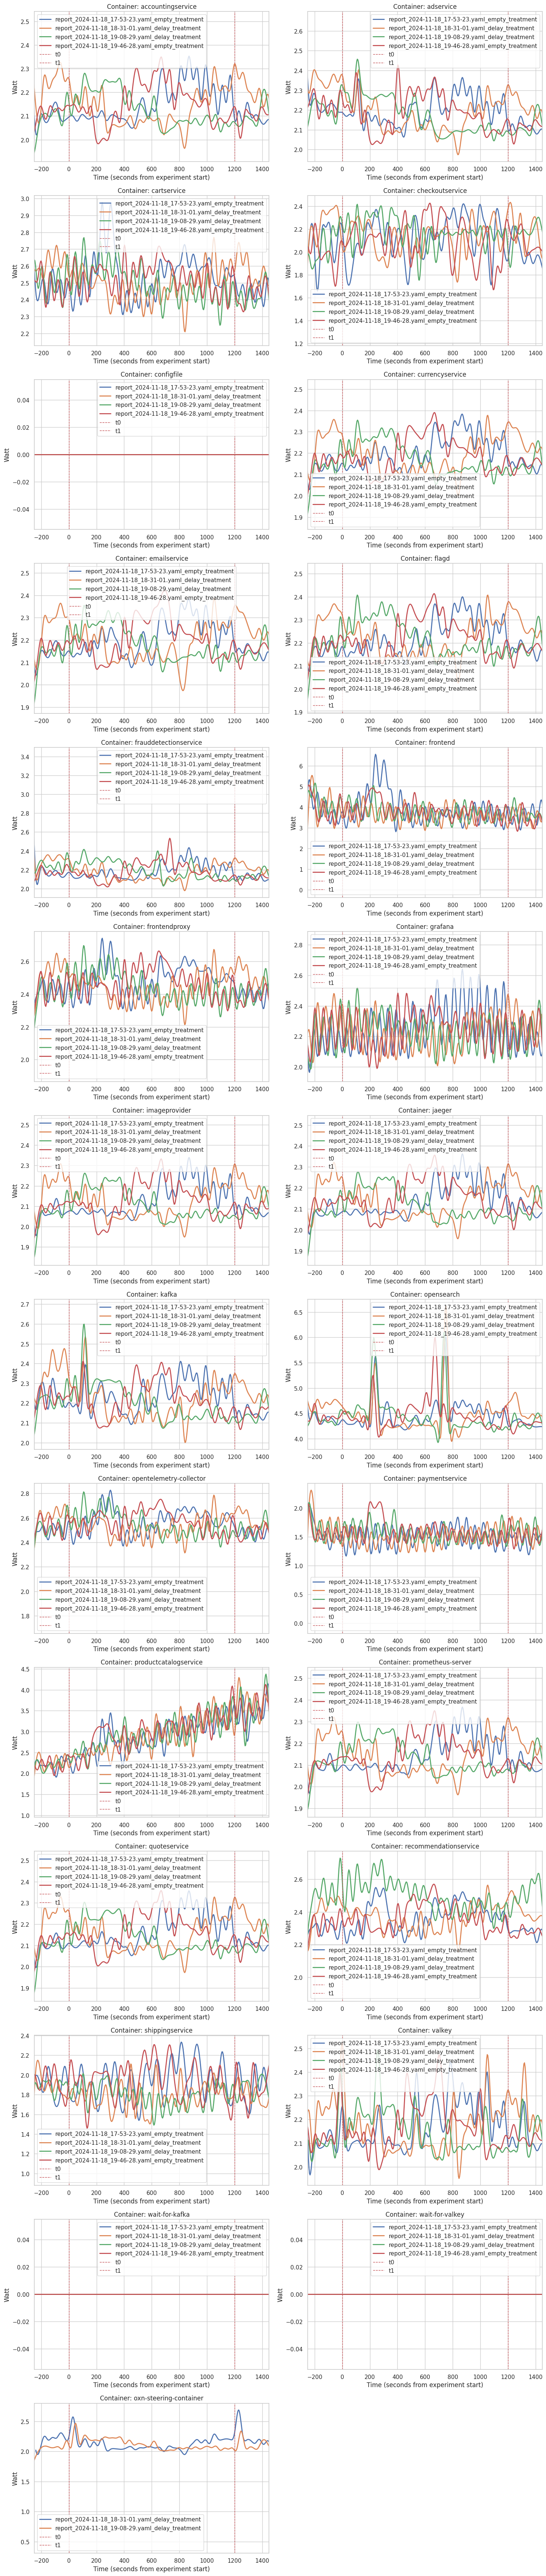

In [45]:

# Directory containing reports
report_directory = "reports/"
treatment_names = ["delay_treatment", "empty_treatment", "increase_otel_metric_interval"]
#                       baseline                            delay 1m                            delay 1s                        5% sampling
report_names = ["report_2024-11-18_17-53-23.yaml", "report_2024-11-18_18-31-01.yaml", "report_2024-11-18_19-08-29.yaml", "report_2024-11-18_19-46-28.yaml"]

response_name = "pods_kepler_joules_all"

cached_dataframes_kepler_pods, combined_df, treatment_start_time, treatment_end_time = load_reports_and_normalize_time(cached_dataframes_kepler_pods, report_directory, response_name, treatment_names, report_names)

#plot_kepler_metrics_per_pod(combined_df, response_name, treatment_end_time, treatment_start_time)

plot_kepler_metrics_per_pod_seaborn(combined_df, response_name, treatment_end_time, treatment_start_time)

#plot_kepler_metrics_per_pod(report_directory, "recommendationservice_kepler_other_joules_all", treatment_names, report_names)



Using cached dataframes.
timestamp
2024-11-18 16:48:24.002000093    -600.001061
2024-11-18 16:49:24.002000093    -540.001061
2024-11-18 16:49:54.002000093    -510.001061
2024-11-18 16:50:24.002000093    -480.001061
2024-11-18 16:50:54.002000093    -450.001061
                                    ...     
2024-11-18 17:21:24.002000093    1379.998939
2024-11-18 17:21:54.002000093    1409.998939
2024-11-18 17:22:24.002000093    1439.998939
2024-11-18 17:22:54.002000093    1469.998939
2024-11-18 17:23:24.002000093    1499.998939
Name: experiment_seconds, Length: 70, dtype: float64
timestamp
2024-11-18 17:26:05.438999891    -600.000533
2024-11-18 17:27:05.438999891    -540.000533
2024-11-18 17:27:35.438999891    -510.000533
2024-11-18 17:28:05.438999891    -480.000533
2024-11-18 17:28:35.438999891    -450.000533
                                    ...     
2024-11-18 17:59:05.438999891    1379.999467
2024-11-18 17:59:35.438999891    1409.999467
2024-11-18 18:00:05.438999891    1439.999467
20

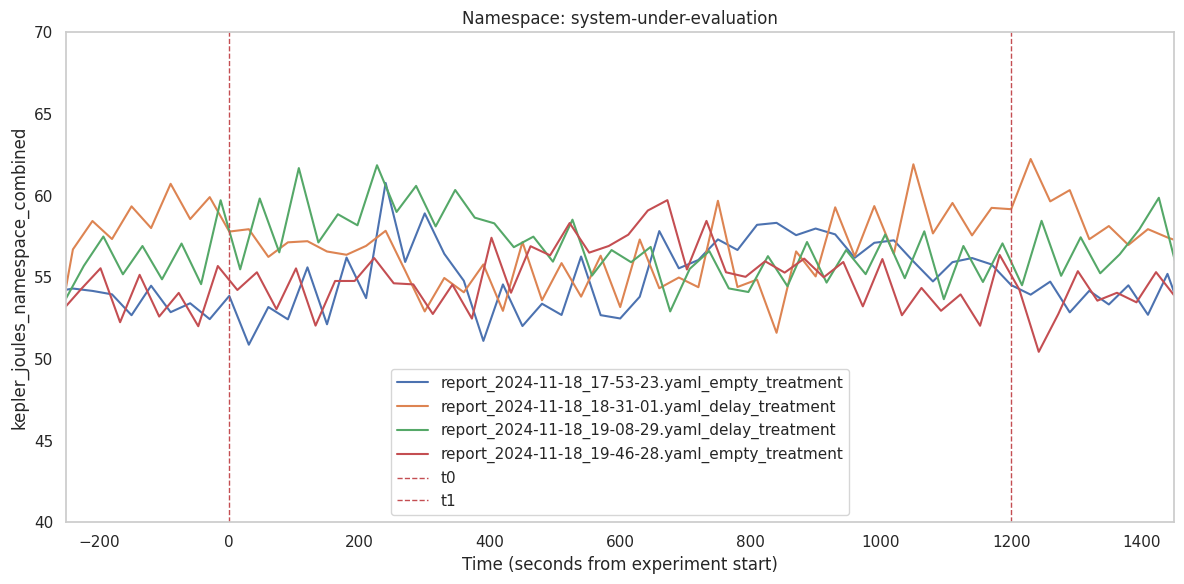

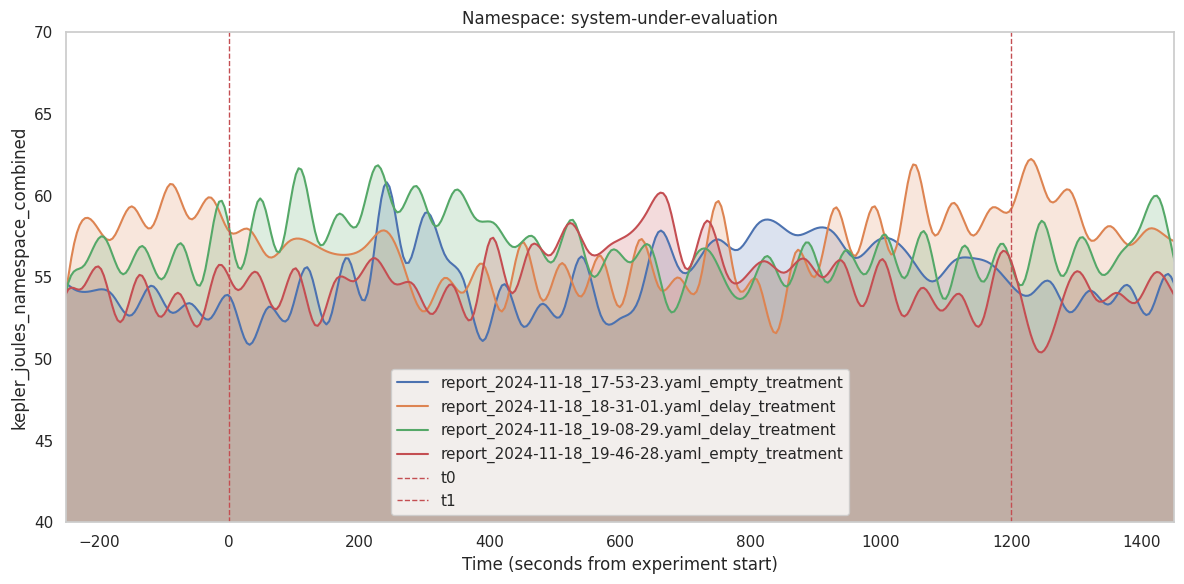

In [52]:
# uncomment to reset cache
#cached_dataframes_kepler_namespace = []


# Directory containing reports
report_directory = "reports"
treatment_names = ["delay_treatment", "empty_treatment", "increase_otel_metric_interval"]
#                       baseline                            delay 1m                            delay 1s                        5% sampling
report_names = ["report_2024-11-18_17-53-23.yaml", "report_2024-11-18_18-31-01.yaml", "report_2024-11-18_19-08-29.yaml", "report_2024-11-18_19-46-28.yaml"]

response_name = "kepler_joules_namespace_combined"

cached_dataframes_kepler_namespace, combined_df, treatment_start_time, treatment_end_time = load_reports_and_normalize_time(cached_dataframes_kepler_namespace, report_directory, response_name, treatment_names, report_names)




#plot_kepler_metrics_per_pod(combined_df, response_name, treatment_end_time, treatment_start_time)

#plot_kepler_metrics_per_pod(report_directory, "recommendationservice_kepler_other_joules_all", treatment_names, report_names)

plot_kepler_metrics(combined_df, response_name, treatment_end_time, treatment_start_time, "system-under-evaluation")
plot_kepler_metrics_seaborn(combined_df, response_name, treatment_end_time, treatment_start_time, "system-under-evaluation")



## calculating power consumption per Pod

In [53]:
# Directory containing reports
report_directory = "reports"

report_base = load_report_interactions(report_directory, report_names[0], "pods_kepler_joules_all_absolute", "empty_treatment")
report_delay = load_report_interactions(report_directory, report_names[1], "pods_kepler_joules_all_absolute", "delay_treatment")
report_delay_1s = load_report_interactions(report_directory, report_names[2], "pods_kepler_joules_all_absolute", "delay_treatment")
report_5percent = load_report_interactions(report_directory, report_names[3], "pods_kepler_joules_all_absolute", "empty_treatment")

Found 1 interactions for report_2024-11-18_17-53-23.yaml and empty_treatment.
Found 1 interactions for report_2024-11-18_18-31-01.yaml and delay_treatment.
Found 1 interactions for report_2024-11-18_19-08-29.yaml and delay_treatment.
Found 1 interactions for report_2024-11-18_19-46-28.yaml and empty_treatment.


In [54]:
def get_treatment_start_end(interaction, treatment_name):
    treatment_start_end_values = {}
    
    number_of_containers = len(interaction.response_data["container_name"].unique())
    #print(f"Interaction: {interaction.treatment_name} with {number_of_containers} containers")
    # Assuming `interaction.response_data` is your dataframe
    for container_name, df in interaction.response_data.groupby("container_name"):
        
        #print(f"Container: {container_name} - Treatment: {treatment_name}")
        # Filter for rows where treatment is "Treatment"
        treatment_df = df[df[treatment_name] == treatment_name]
    
        
        if not treatment_df.empty:
           # get the first and last value of the treatment
            treatment_start = treatment_df["pods_kepler_joules_all_absolute"].iloc[0]
            treatment_end = treatment_df["pods_kepler_joules_all_absolute"].iloc[-1]
            
            
            difference = treatment_end - treatment_start
            
            
            treatment_start_end_values[container_name] = (treatment_start, treatment_end, difference)
            
            #print(f"Container: {container_name}, Treatment start: {treatment_start}, Treatment end: {treatment_end}")
            #print(f"Difference: {difference}")
            if difference < 0:
                print(f"Container: {container_name}, Negative difference found.")
        else:
            print(f"Container: {container_name}, No 'Treatment' period found.")

    return treatment_start_end_values



def modify_treatment(report, report_name, treatment_name):
    """if report:
        # Add treatment information to the DataFrame
        report.response_data["treatment"] = f"{report_name}_{treatment_name}"
        report.response_data["treatment_start"] = report.treatment_start
        report.response_data["treatment_end"] = report.treatment_end """
    return report


# Example usage
treatment_start_end = {}

report_base_interaction_modified = modify_treatment(report_base, report_names[0], "empty_treatment")
report_delay_interaction_modified = modify_treatment(report_delay, report_names[1], "delay_treatment")
report_delay_1s_interaction_modified = modify_treatment(report_delay_1s, report_names[2], "delay_treatment")
report_5percent_interaction_modified = modify_treatment(report_5percent, report_names[3], "empty_treatment")

treatment_start_end_base = get_treatment_start_end(report_base_interaction_modified, "empty_treatment")
treatment_start_end_delay = get_treatment_start_end(report_delay_interaction_modified, "delay_treatment")
treatment_start_end_delay_1s = get_treatment_start_end(report_delay_1s_interaction_modified, "delay_treatment")
treatment_start_end_5percent = get_treatment_start_end(report_5percent_interaction_modified, "empty_treatment")

for container_name, values in treatment_start_end_base.items():
    percentage_differece_delay = (treatment_start_end_delay[container_name][2] - treatment_start_end_base[container_name][2]) / treatment_start_end_base[container_name][2] * 100
    percentage_differece_delay_1s = (treatment_start_end_delay_1s[container_name][2] - treatment_start_end_base[container_name][2]) / treatment_start_end_base[container_name][2] * 100
    percentage_differece_5percent = (treatment_start_end_5percent[container_name][2] - treatment_start_end_base[container_name][2]) / treatment_start_end_base[container_name][2] * 100
    print(f"Container: {container_name}")
    print(f"Base Treatment: {treatment_start_end_base[container_name][2]}")
    print(f"Delay Treatment: {treatment_start_end_delay[container_name][2]} ({percentage_differece_delay:.2f}%)")
    print(f"Delay 1s Treatment: {treatment_start_end_delay_1s[container_name][2]} ({percentage_differece_delay_1s:.2f}%)")
    print(f"5% Treatment: {treatment_start_end_5percent[container_name][2]} ({percentage_differece_5percent:.2f}%)")
    print("-----------------------------------------------")
        

Container: emailservice, Negative difference found.
Container: emailservice, Negative difference found.
Container: emailservice, Negative difference found.
Container: emailservice, Negative difference found.
Container: oxn-steering-container, No 'Treatment' period found.
Container: accountingservice
Base Treatment: 2529.183
Delay Treatment: 2488.3500000000004 (-1.61%)
Delay 1s Treatment: 2494.977 (-1.35%)
5% Treatment: 2518.8509999999997 (-0.41%)
-----------------------------------------------
Container: adservice
Base Treatment: 2577.807
Delay Treatment: 2530.4370000000004 (-1.84%)
Delay 1s Treatment: 2538.9810000000007 (-1.51%)
5% Treatment: 2563.8509999999997 (-0.54%)
-----------------------------------------------
Container: cartservice
Base Treatment: 2995.782
Delay Treatment: 2903.3369999999995 (-3.09%)
Delay 1s Treatment: 2931.771 (-2.14%)
5% Treatment: 2968.767 (-0.90%)
-----------------------------------------------
Container: checkoutservice
Base Treatment: 2495.9519999999998

/tmp/ipykernel_121403/1095221315.py:59: RuntimeWarning: invalid value encountered in scalar divide
  percentage_differece_delay = (treatment_start_end_delay[container_name][2] - treatment_start_end_base[container_name][2]) / treatment_start_end_base[container_name][2] * 100
/tmp/ipykernel_121403/1095221315.py:60: RuntimeWarning: invalid value encountered in scalar divide
  percentage_differece_delay_1s = (treatment_start_end_delay_1s[container_name][2] - treatment_start_end_base[container_name][2]) / treatment_start_end_base[container_name][2] * 100
/tmp/ipykernel_121403/1095221315.py:61: RuntimeWarning: invalid value encountered in scalar divide
  percentage_differece_5percent = (treatment_start_end_5percent[container_name][2] - treatment_start_end_base[container_name][2]) / treatment_start_end_base[container_name][2] * 100


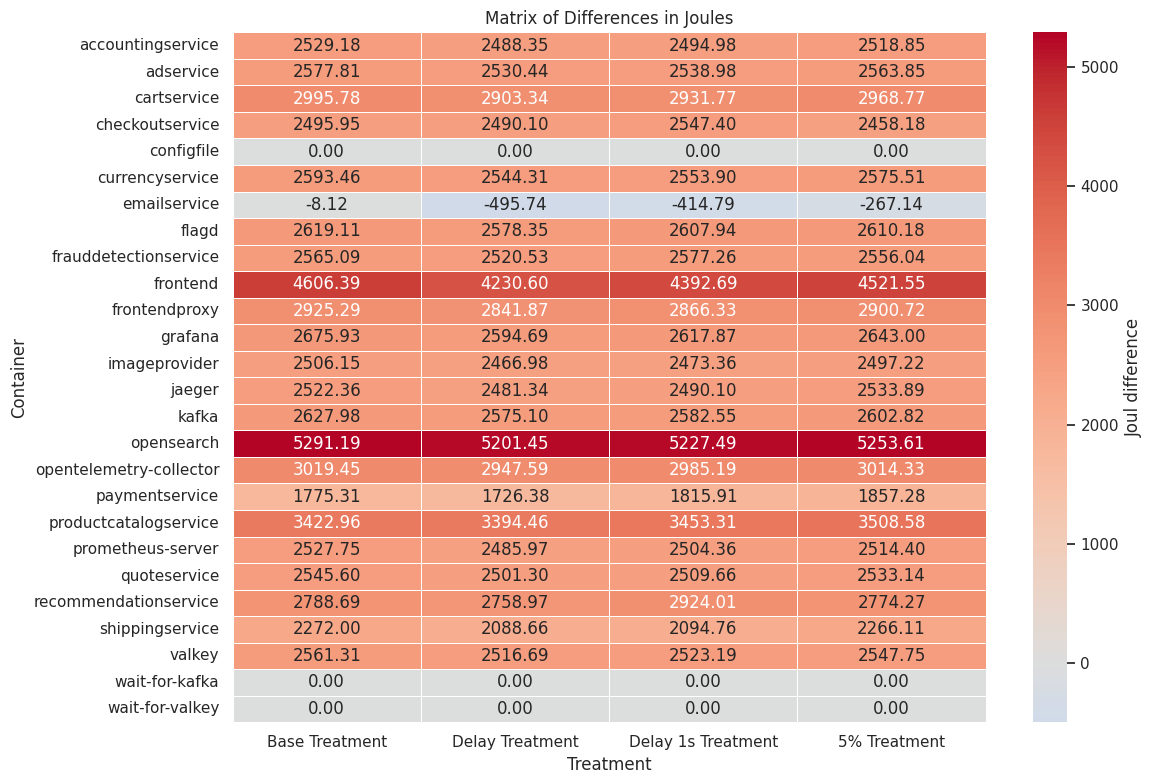

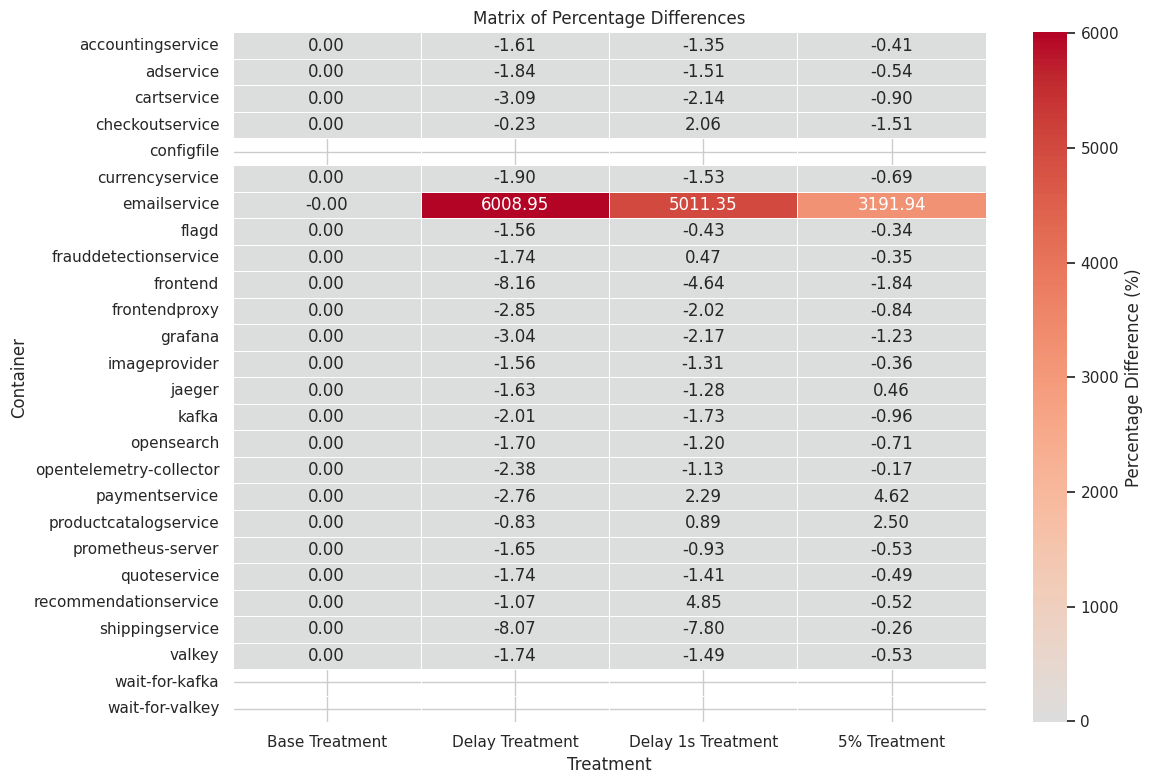

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def generate_difference_matrix_percentage(treatment_start_end_base, treatment_start_end_delay, treatment_start_end_delay_1s, treatment_start_end_5percent):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())
    data = {
        "Base Treatment": [treatment_start_end_base[c][2] for c in containers],
        "Delay Treatment": [treatment_start_end_delay[c][2] for c in containers],
        "Delay 1s Treatment": [treatment_start_end_delay_1s[c][2] for c in containers],
        "5% Treatment": [treatment_start_end_5percent[c][2] for c in containers],
    }

    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)

    # Calculate percentage differences relative to the base treatment
    percentage_difference = df.copy()
    for col in ["Base Treatment", "Delay Treatment", "Delay 1s Treatment", "5% Treatment"]:
        percentage_difference[col] = (df[col] - df["Base Treatment"]) / df["Base Treatment"] * 100

    # Drop the base column from the percentage difference DataFrame
    #percentage_difference.drop(columns=["Base Treatment"], inplace=True)

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_difference,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Percentage Difference (%)'}
    )
    plt.title("Matrix of Percentage Differences")
    plt.xlabel("Treatment")
    plt.ylabel("Container")
    plt.tight_layout()
    plt.show()

def generate_difference_matrix(treatment_start_end_base, treatment_start_end_delay, treatment_start_end_delay_1s, treatment_start_end_5percent):
    # Prepare data for matrix
    containers = list(treatment_start_end_base.keys())
    data = {
        "Base Treatment": [treatment_start_end_base[c][2] for c in containers],
        "Delay Treatment": [treatment_start_end_delay[c][2] for c in containers],
        "Delay 1s Treatment": [treatment_start_end_delay_1s[c][2] for c in containers],
        "5% Treatment": [treatment_start_end_5percent[c][2] for c in containers],
    }

    # Create a DataFrame
    df = pd.DataFrame(data, index=containers)

    # Calculate percentage differences relative to the base treatment
    percentage_difference = df.copy()
    for col in ["Base Treatment", "Delay Treatment", "Delay 1s Treatment", "5% Treatment"]:
        percentage_difference[col] = df[col]

    # Drop the base column from the percentage difference DataFrame
    #percentage_difference.drop(columns=["Base Treatment"], inplace=True)

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        percentage_difference,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Joul difference'}
    )
    plt.title("Matrix of Differences in Joules")
    plt.xlabel("Treatment")
    plt.ylabel("Container")
    plt.tight_layout()
    plt.show()


# Example usage: Generate the matrix
generate_difference_matrix(
    treatment_start_end_base,
    treatment_start_end_delay,
    treatment_start_end_delay_1s,
    treatment_start_end_5percent,
)

generate_difference_matrix_percentage(
    treatment_start_end_base,
    treatment_start_end_delay,
    treatment_start_end_delay_1s,
    treatment_start_end_5percent,
)


## Powerconsumption of namespace

In [59]:
# Directory containing reports
report_directory = "reports"

report_base_kepler_namespace = load_report_interactions(report_directory, report_names[0], "kepler_joules_namespace_combined_absolute", "empty_treatment")
report_delay_kepler_namespace = load_report_interactions(report_directory, report_names[1], "kepler_joules_namespace_combined_absolute", "delay_treatment")
report_delay_1s_kepler_namespace = load_report_interactions(report_directory, report_names[2], "kepler_joules_namespace_combined_absolute", "delay_treatment")
report_sampling_5_percent_kepler_namespace = load_report_interactions(report_directory, report_names[3], "kepler_joules_namespace_combined_absolute", "empty_treatment")

assert report_base_kepler_namespace is not None
assert report_delay_kepler_namespace is not None
assert report_delay_1s_kepler_namespace is not None
assert report_sampling_5_percent_kepler_namespace is not None

Found 1 interactions for report_2024-11-18_17-53-23.yaml and empty_treatment.
Found 1 interactions for report_2024-11-18_18-31-01.yaml and delay_treatment.
Found 1 interactions for report_2024-11-18_19-08-29.yaml and delay_treatment.
Found 1 interactions for report_2024-11-18_19-46-28.yaml and empty_treatment.


In [60]:
def get_kepler_total_energy_consumption(interaction, treatment_name):
    treatment_start_end_values = {}
    for container_namespace, df in interaction.response_data.groupby("container_namespace"):
        treatment_df = df[df[treatment_name] == treatment_name]
        if not treatment_df.empty:
            # get the first and last value of the treatment
            treatment_start = treatment_df["kepler_joules_namespace_combined_absolute"].iloc[0]
            treatment_end = treatment_df["kepler_joules_namespace_combined_absolute"].iloc[-1]
            
            
            difference = treatment_end - treatment_start
            
            
            treatment_start_end_values[container_namespace] = (treatment_start, treatment_end, difference)
    return treatment_start_end_values

treatment_start_end = {}

values_base_kepler_namespace = get_kepler_total_energy_consumption(report_base_kepler_namespace, "empty_treatment")
values_delay_kepler_namespace = get_kepler_total_energy_consumption(report_delay_kepler_namespace, "delay_treatment")
values_delay_1s_kepler_namespace = get_kepler_total_energy_consumption(report_delay_1s_kepler_namespace, "delay_treatment")
values_sampling_5_percent_kepler_namespace = get_kepler_total_energy_consumption(report_sampling_5_percent_kepler_namespace, "empty_treatment")

for container_namespace, values in values_base_kepler_namespace.items():
    percentage_differece_delay = (values_delay_kepler_namespace[container_namespace][2] - values_base_kepler_namespace[container_namespace][2]) / values_base_kepler_namespace[container_namespace][2] * 100
    percentage_differece_delay_1s = (values_delay_1s_kepler_namespace[container_namespace][2] - values_delay_kepler_namespace[container_namespace][2]) / values_base_kepler_namespace[container_namespace][2] * 100
    percentage_differece_5percent = (values_sampling_5_percent_kepler_namespace[container_namespace][2] - values_delay_kepler_namespace[container_namespace][2]) / values_base_kepler_namespace[container_namespace][2] * 100
    print(f"Namespace: {container_namespace}")
    print(f"Base Treatment: {values_base_kepler_namespace[container_namespace][2]}")
    print(f"Delay Treatment: {values_delay_kepler_namespace[container_namespace][2]} ({percentage_differece_delay:.2f}%)")
    print(f"Delay 1s Treatment: {values_delay_1s_kepler_namespace[container_namespace][2]} ({percentage_differece_delay_1s:.2f}%)")
    print(f"5% Treatment: {values_sampling_5_percent_kepler_namespace[container_namespace][2]} ({percentage_differece_5percent:.2f}%)")
    print("-----------------------------------------------")

Namespace: system-under-evaluation
Base Treatment: 62436.653999999995
Delay Treatment: 62838.72 (0.64%)
Delay 1s Treatment: 63780.315 (1.51%)
5% Treatment: 61952.901 (-1.42%)
-----------------------------------------------
